In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt


def get_ds_infos():
    """
    Read the file includes data subject information.
    
    Data Columns:
    0: code [1-24]
    1: weight [kg]
    2: height [cm]
    3: age [years]
    4: gender [0:Female, 1:Male]
    
    Returns:
        A pandas DataFrame that contains inforamtion about data subjects' attributes 
    """ 

    dss = pd.read_csv("data_subjects_info.csv")
    print("[INFO] -- Data subjects' information is imported.")
    
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """
    Select the sensors and the mode to shape the final dataset.
    
    Args:
        data_types: A list of sensor data type from this list: [attitude, gravity, rotationRate, userAcceleration] 

    Returns:
        It returns a list of columns to use for creating time-series from files.
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])

    return dt_list


def creat_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True, combine_grav_acc=False):
    """
    Args:
        dt_list: A list of columns that shows the type of data we want.
        act_labels: list of activites
        trial_codes: list of trials
        mode: It can be "raw" which means you want raw data
        for every dimention of each data type,
        [attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)].
        or it can be "mag" which means you only want the magnitude for each data type: (x^2+y^2+z^2)^(1/2)
        labeled: True, if we want a labeld dataset. False, if we only want sensor values.
        combine_grav_acc: True, means adding each axis of gravity to  corresponding axis of userAcceleration.
    Returns: 
        It returns a time-series of sensor data.
    
    """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+7)) # "7" --> [act, code, weight, height, age, gender, trial] 
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = 'A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                
                if combine_grav_acc:
                    raw_data["userAcceleration.x"] = raw_data["userAcceleration.x"].add(raw_data["gravity.x"])
                    raw_data["userAcceleration.y"] = raw_data["userAcceleration.y"].add(raw_data["gravity.y"])
                    raw_data["userAcceleration.z"] = raw_data["userAcceleration.z"].add(raw_data["gravity.z"])
                
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id,
                            sub_id-1,
                            ds_list["weight"][sub_id-1],
                            ds_list["height"][sub_id-1],
                            ds_list["age"][sub_id-1],
                            ds_list["gender"][sub_id-1],
                            trial          
                           ]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset
#________________________________
#________________________________

def ts_to_secs(dataset, w, s, standardize = False, **options):
    
    data = dataset[dataset.columns[:-7]].values    
    act_labels = dataset["act"].values
    id_labels = dataset["id"].values
    trial_labels = dataset["trial"].values

    mean = 0
    std = 1
    if standardize:
        ## Standardize each sensor’s data to have a zero mean and unity standard deviation.
        ## As usual, we normalize test dataset by training dataset's parameters 
        if options:
            mean = options.get("mean")
            std = options.get("std")
            print("[INFO] -- Test Data has been standardized")
        else:
            mean = data.mean(axis=0)
            std = data.std(axis=0)
            print("[INFO] -- Training Data has been standardized: the mean is = "+str(mean)+" ; and the std is = "+str(std))            

        data -= mean
        data /= std
    else:
        print("[INFO] -- Without Standardization.....")

    ## We want the Rows of matrices show each Feature and the Columns show time points.
    data = data.T

    m = data.shape[0]   # Data Dimension 
    ttp = data.shape[1] # Total Time Points
    number_of_secs = int(round(((ttp - w)/s)))

    ##  Create a 3D matrix for Storing Sections  
    secs_data = np.zeros((number_of_secs , m , w ))
    act_secs_labels = np.zeros(number_of_secs)
    id_secs_labels = np.zeros(number_of_secs)

    k=0
    for i in range(0 , ttp-w, s):
        j = i // s
        if j >= number_of_secs:
            break
        if id_labels[i] != id_labels[i+w-1]: 
            continue
        if act_labels[i] != act_labels[i+w-1]: 
            continue
        if trial_labels[i] != trial_labels[i+w-1]:
            continue
            
        secs_data[k] = data[:, i:i+w]
        act_secs_labels[k] = act_labels[i].astype(int)
        id_secs_labels[k] = id_labels[i].astype(int)
        k = k+1
        
    secs_data = secs_data[0:k]
    act_secs_labels = act_secs_labels[0:k]
    id_secs_labels = id_secs_labels[0:k]
    return secs_data, act_secs_labels, id_secs_labels, mean, std
##________________________________________________________________


ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13],
}

In [2]:
import tensorflow as tf 
import keras 
import keras.backend as K

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from collections import Counter

from keras import regularizers
from keras.models import Sequential, Model, load_model, model_from_json 
from keras.utils import to_categorical
from keras.layers import Input, Dense, Flatten, Reshape, Concatenate,  Dropout 
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.layers.advanced_activations import LeakyReLU
from scipy.signal import resample
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}


class Enc_Reg:
    l2p = 0.001
    @staticmethod
    def early_layers(inp, fm = (1,3), hid_act_func="relu"):
        # Start
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Enc_Reg.l2p), activation=hid_act_func)(inp)
        x = Dropout(0.25)(x)
        
        # 1
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Enc_Reg.l2p), activation=hid_act_func)(x)
        x = Dropout(0.25)(x)


        return x
    
    @staticmethod
    def late_layers(inp, num_classes, fm = (1,3), act_func="softmax", hid_act_func="relu", b_name="Identifier"):
        # 2
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Enc_Reg.l2p), activation=hid_act_func)(inp)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)
        
        # 3
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Enc_Reg.l2p), activation=hid_act_func)(x)
        x = Dropout(0.25)(x)
        
        #4
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Enc_Reg.l2p), activation=hid_act_func)(x)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)
        
        
        # End
        x = Flatten()(x)
        x = Dense(128, kernel_regularizer=regularizers.l2(Enc_Reg.l2p), activation=hid_act_func)(x)
        x = Dropout(0.5)(x)
        x = Dense(32, kernel_regularizer=regularizers.l2(Enc_Reg.l2p), activation=hid_act_func)(x)
        x = Dropout(0.5)(x)
        x = Dense(num_classes, activation=act_func, name = b_name)(x)

        return x
   
    @staticmethod
    def build(height, width, num_classes, name, fm = (1,3), act_func="softmax",hid_act_func="relu"):
        inp = Input(shape=(height, width, 1))
        early = Enc_Reg.early_layers(inp, fm, hid_act_func=hid_act_func)
        late  = Enc_Reg.late_layers(early, num_classes, fm, act_func=act_func, hid_act_func=hid_act_func)
        model = Model(inputs=inp, outputs=late ,name=name)
        return model


class Dec_Reg:
    l2p = 0.001
    @staticmethod
    def early_layers(inp, fm = (1,3), hid_act_func="relu"):
        # Start
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Dec_Reg.l2p), activation=hid_act_func)(inp)
        x = Dropout(0.25)(x)
        
        # 1
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Dec_Reg.l2p), activation=hid_act_func)(x)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)


        return x
    
    @staticmethod
    def late_layers(inp, num_classes, fm = (1,3), act_func="softmax", hid_act_func="relu", b_name="Identifier"):
        # 2
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Dec_Reg.l2p), activation=hid_act_func)(inp)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)
        
        # 3
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Dec_Reg.l2p), activation=hid_act_func)(x)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)
        
        #4
        x = Conv2D(32, fm, padding="same", kernel_regularizer=regularizers.l2(Dec_Reg.l2p), activation=hid_act_func)(x)
        x = MaxPooling2D(pool_size=(1, 2))(x)
        x = Dropout(0.25)(x)
        
        
        # End
        x = Flatten()(x)
        x = Dense(256, kernel_regularizer=regularizers.l2(Dec_Reg.l2p), activation=hid_act_func)(x)
        x = Dropout(0.5)(x)
        x = Dense(64, kernel_regularizer=regularizers.l2(Dec_Reg.l2p), activation=hid_act_func)(x)
        x = Dropout(0.5)(x)
        x = Dense(num_classes, activation=act_func, name = b_name)(x)

        return x
   
    @staticmethod
    def build(height, width, num_classes, name, fm = (1,3), act_func="softmax",hid_act_func="relu"):
        inp = Input(shape=(height, width, 1))
        early = Dec_Reg.early_layers(inp, fm, hid_act_func=hid_act_func)
        late  = Dec_Reg.late_layers(early, num_classes, fm, act_func=act_func, hid_act_func=hid_act_func)
        model = Model(inputs=inp, outputs=late ,name=name)
        return model


class Encoder:
    l2p = 0.001
    @staticmethod
    def layers(x, fm = (1,3), act_func="linear", hid_act_func="relu", b_name="Encoder"):
        x = Conv2D(100, fm, activation=hid_act_func, kernel_regularizer=regularizers.l2(Encoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Conv2D(100, fm, activation=hid_act_func, kernel_regularizer=regularizers.l2(Encoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(1,2))(x)

        x = Conv2D(100, fm, activation=hid_act_func,kernel_regularizer=regularizers.l2(Encoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(1,2))(x)

        x = Conv2D(100, fm, activation=hid_act_func, padding='same',kernel_regularizer=regularizers.l2(Encoder.l2p))(x)
        x = BatchNormalization()(x)
        
        x = Conv2D(1, fm, activation=act_func, padding='same', name = b_name)(x) 
        y = BatchNormalization()(x)

        return y
   
    @staticmethod
    def build(height, width, fm=(1,3), act_func="linear", hid_act_func="relu"):
        inp = Input(shape=(height, width,1))
        enc = Encoder.layers(inp, fm, act_func=act_func, hid_act_func=hid_act_func)
        model = Model(inputs=inp, outputs=enc ,name="Enc")
        return model

class Decoder:
    l2p = 0.001
    @staticmethod
    def layers(x, height, width, noise_length, fm = (1,3), act_func="linear", hid_act_func="relu", b_name="Decoder"):
        
        x = Conv2DTranspose(100, fm, strides = (1, 1), activation=hid_act_func,kernel_regularizer=regularizers.l2(Decoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2DTranspose(100, fm,  strides = (1, 2), activation=hid_act_func,kernel_regularizer=regularizers.l2(Decoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2DTranspose(100, fm, strides = (1, 2), activation=hid_act_func,kernel_regularizer=regularizers.l2(Decoder.l2p), padding='same')(x)
        x = BatchNormalization()(x)

        x = Conv2DTranspose(100, fm, strides = (1, 1), activation=hid_act_func,kernel_regularizer=regularizers.l2(Decoder.l2p),  padding='same')(x)
        
        xh = Conv2D(1, fm, activation=act_func, padding='same', name = b_name)(x)
        return xh
   
    @staticmethod
    def build(height, width, noise_length=0, fm = (1,3), act_func="linear", hid_act_func="relu"):
        inp = Input(shape=(height, width+noise_length,1))
        dec  = Decoder.layers(inp,height, width, noise_length, fm, act_func=act_func, hid_act_func=hid_act_func)
        model = Model(inputs=inp, outputs=dec ,name="Dec")
        return model        

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [14]:
## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["rotationRate","userAcceleration"]
mode = "mag"
cga = True # Add gravity to acceleration or not
print("[INFO] -- Selected sensor data types: "+str(sdt)+" -- Mode: "+str(mode)+" -- Grav+Acc: "+str(cga))    

act_labels = ACT_LABELS [0:4]
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
dataset = creat_time_series(dt_list, act_labels, trial_codes, mode=mode, labeled=True, combine_grav_acc = cga)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    

#*****************
TRAIN_TEST_TYPE = "subject" # "subject" or "trial"
#*****************

if TRAIN_TEST_TYPE == "subject":
    test_ids = [4,9,11,21]
    print("[INFO] -- Test IDs: "+str(test_ids))
    test_ts = dataset.loc[(dataset['id'].isin(test_ids))]
    train_ts = dataset.loc[~(dataset['id'].isin(test_ids))]
else:
    test_trail = [11,12,13,14,15,16]  
    print("[INFO] -- Test Trials: "+str(test_trail))
    test_ts = dataset.loc[(dataset['trial'].isin(test_trail))]
    train_ts = dataset.loc[~(dataset['trial'].isin(test_trail))]

    
print("[INFO] -- Shape of Train Time-Series :"+str(train_ts.shape))
print("[INFO] -- Shape of Test Time-Series :"+str(test_ts.shape))


[INFO] -- Selected sensor data types: ['rotationRate', 'userAcceleration'] -- Mode: mag -- Grav+Acc: True
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog']
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(767660, 9)
[INFO] -- Test IDs: [4, 9, 11, 21]
[INFO] -- Shape of Train Time-Series :(646207, 9)
[INFO] -- Shape of Test Time-Series :(121453, 9)


In [15]:
val_trail = [11,12,13,14,15,16]
val_ts = train_ts.loc[(train_ts['trial'].isin(val_trail))]
train_ts = train_ts.loc[~(train_ts['trial'].isin(val_trail))]
print("[INFO] -- Shape of Train Time-Series :"+str(train_ts.shape))
print("[INFO] -- Shape of Test Time-Series :"+str(val_ts.shape))

[INFO] -- Shape of Train Time-Series :(523129, 9)
[INFO] -- Shape of Test Time-Series :(123078, 9)


In [16]:
#************
## HERE ##

## This Variable Defines the Size of Sliding Window
## ( e.g. 100 means in each snapshot we just consider 100 consecutive observations of each sensor) 
w = 128 # 50 Equals to 1 second for MotionSense Dataset (it is on 50Hz samplig rate)
## Here We Choose Step Size for Building Diffrent Snapshots from Time-Series Data
## ( smaller step size will increase the amount of the instances and higher computational cost may be incurred )
s = 10
train_data, act_train, id_train, train_mean, train_std = ts_to_secs(train_ts.copy(),
                                                                   w,
                                                                   s,
                                                                   standardize = True)

s = 10
val_data, act_val, id_val, val_mean, val_std = ts_to_secs(val_ts.copy(),
                                                              w,
                                                              s,
                                                              standardize = True,
                                                              mean = train_mean, 
                                                              std = train_std)


s = 10
test_data, act_test, id_test, test_mean, test_std = ts_to_secs(test_ts.copy(),
                                                              w,
                                                              s,
                                                              standardize = True,
                                                              mean = train_mean, 
                                                              std = train_std)

print("[INFO] -- Shape of Training Sections: "+str(train_data.shape))
print("[INFO] -- Shape of Training Sections: "+str(val_data.shape))
print("[INFO] -- Shape of Test Sections:  "+str(test_data.shape))

[INFO] -- Training Data has been standardized: the mean is = [2.17728825 1.19431016] ; and the std is = [1.43229632 0.70168121]
[INFO] -- Test Data has been standardized
[INFO] -- Test Data has been standardized
[INFO] -- Shape of Training Sections: (50532, 2, 128)
[INFO] -- Shape of Training Sections: (11288, 2, 128)
[INFO] -- Shape of Test Sections:  (11589, 2, 128)


In [6]:
id_train_labels = to_categorical(id_train)
id_val_labels = to_categorical(id_val)
id_test_labels = to_categorical(id_test)
id_test_labels = np.append(id_test_labels, np.zeros((len(id_test_labels),2)), axis =1)

act_train_labels = to_categorical(act_train)
act_val_labels = to_categorical(act_val)
act_test_labels = to_categorical(act_test)
    
## Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
train_data = np.expand_dims(train_data,axis=3)
print("[INFO] -- Shape of Training Sections:", train_data.shape)
val_data = np.expand_dims(val_data,axis=3)
print("[INFO] -- Validation Sections:"+str(val_data.shape))
test_data = np.expand_dims(test_data,axis=3)
print("[INFO] -- Shape of Training Sections:", test_data.shape)

[INFO] -- Shape of Training Sections: (50532, 2, 128, 1)
[INFO] -- Validation Sections:(11288, 2, 128, 1)
[INFO] -- Shape of Training Sections: (11589, 2, 128, 1)


In [7]:
height = train_data.shape[1]
width = train_data.shape[2]

enc_tmp = Encoder.build(height, width, act_func="linear", hid_act_func="relu")
dec_tmp = Decoder.build(height, width//4, act_func="linear", hid_act_func="relu")
enc_tmp.compile( loss="mean_squared_error", optimizer='adam', metrics=['mse'])
dec_tmp.compile( loss="mean_squared_error", optimizer='adam', metrics=['mse'])
inp_tmp = Input(shape=(height, width,1))
x = enc_tmp(inp_tmp)
x = dec_tmp(x)
enc_dec_tmp = Model(inputs=inp_tmp, outputs=x)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
filepath="cae128__"+str(test_ids)+".best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, early_stop]

 

enc_dec_tmp.compile( loss="mean_squared_error", optimizer='adam', metrics=['mse'])



enc_dec_tmp.fit(train_data, train_data,
                validation_data = (val_data, val_data),
                epochs = 32,
                batch_size = 128,
                verbose = 1,
                callbacks = callbacks_list
               )

enc_dec_tmp.load_weights("cae128__"+str(test_ids)+".best.hdf5")
enc_dec_tmp.compile( loss="mean_squared_error", optimizer='adam', metrics=['mse'])

tz_train = enc_tmp.predict(train_data)
tz_val = enc_tmp.predict(val_data)
tz_test  = enc_tmp.predict(test_data)

print("[INFO] -- Shape tz_train:"+str(tz_train.shape))
print("[INFO] -- Shape tz_val:"+str(tz_val.shape))
print("[INFO] --  Shape tz_test :"+str(tz_test.shape))

[INFO] -- Shape tz_train:(50532, 2, 32, 1)
[INFO] -- Shape tz_val:(11288, 2, 32, 1)
[INFO] --  Shape tz_test :(11589, 2, 32, 1)


In [8]:
ae_train = enc_dec_tmp.predict(train_data)
ae_val = enc_dec_tmp.predict(val_data)
ae_test  = enc_dec_tmp.predict(test_data)

print("[INFO] -- Shape tz_train:"+str(ae_train.shape))
print("[INFO] -- Shape tz_val:"+str(ae_val.shape))
print("[INFO] --  Shape tz_test :"+str(ae_test.shape))

[INFO] -- Shape tz_train:(50532, 2, 128, 1)
[INFO] -- Shape tz_val:(11288, 2, 128, 1)
[INFO] --  Shape tz_test :(11589, 2, 128, 1)


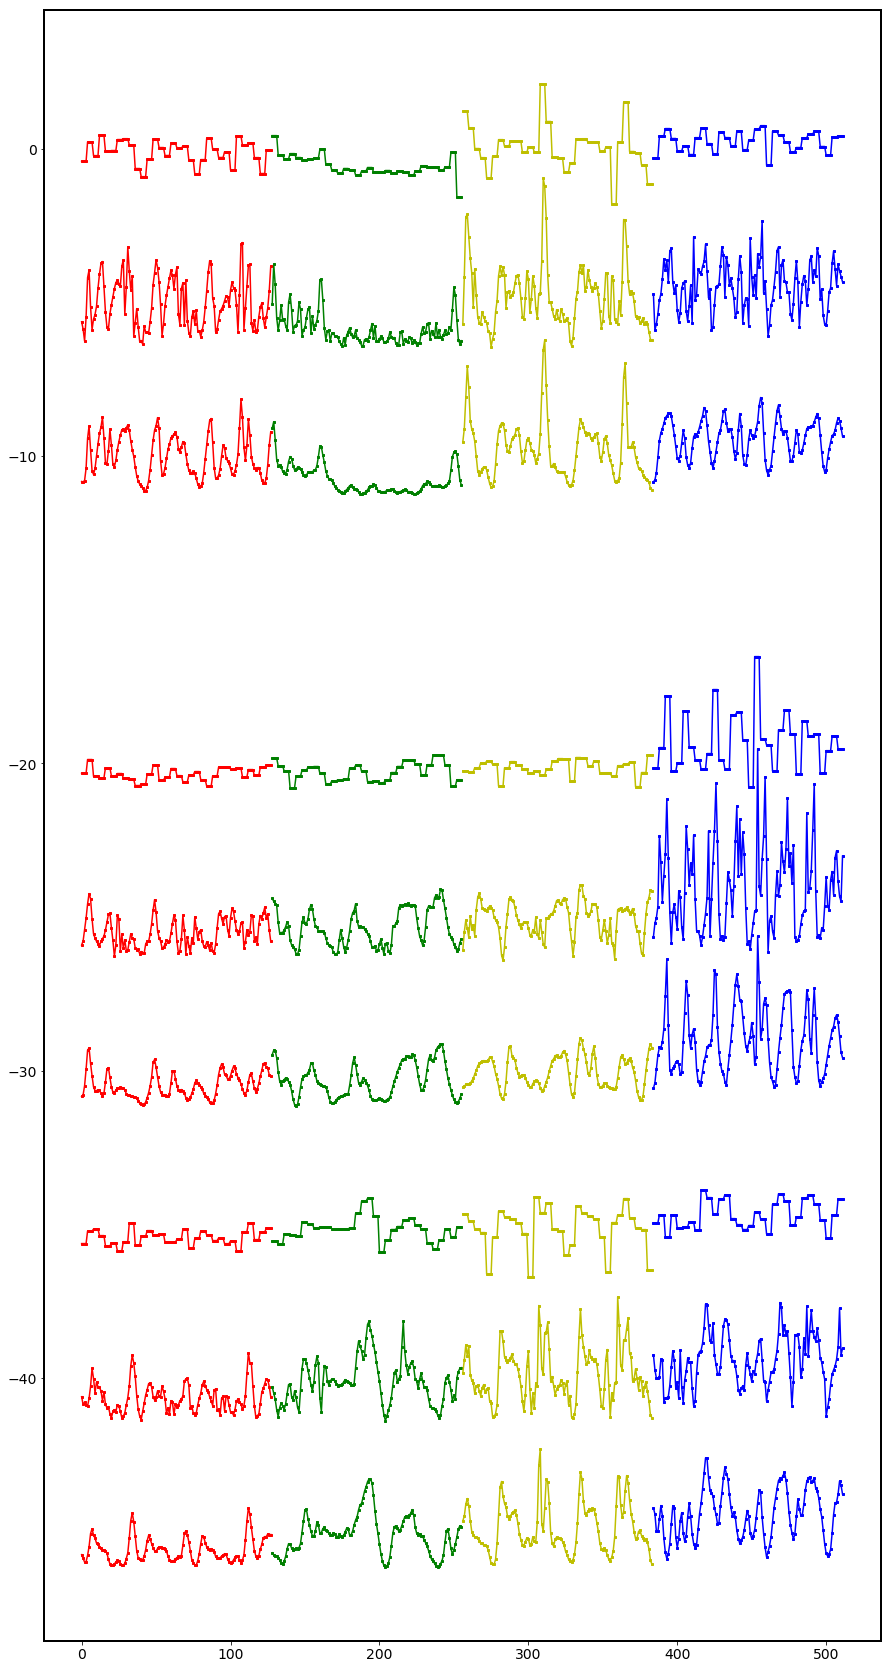

In [9]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,30)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

clr = ["rs-","gs-","ys-","bs-","k*-"]   
lbl = ["DWS","UPS","WLK","JOG","STD"]

rd=500
pts = 128
sens=0
for k in range(4):
    org_x_train = train_data[act_train_labels[:,k]==1.0][rd,sens,:,0] - 5
    tra_x_train = ae_train[act_train_labels[:,k]==1.0][rd,sens,:,0]-10
    tz_x_train = tz_train[act_train_labels[:,k]==1.0][rd,sens,:,0]
    
    org_x_test = test_data[act_test_labels[:,k]==1.0][rd,sens,:,0]-25   
    tra_x_test = ae_test[act_test_labels[:,k]==1.0][rd,sens,:,0]-30
    tz_x_test = tz_test[act_test_labels[:,k]==1.0][rd,sens,:,0]-20
    
    org_x_val = val_data[act_val_labels[:,k]==1.0][rd,sens,:,0]-40   
    tra_x_val = ae_val[act_val_labels[:,k]==1.0][rd,sens,:,0]-45
    tz_x_val = tz_val[act_val_labels[:,k]==1.0][rd,sens,:,0]-35

    plt.plot(list(range(pts*k,pts*(k+1))), tra_x_train, clr[k], label=lbl[k], markersize = 2)
    plt.plot(list(range(pts*k,pts*(k+1))), org_x_train, clr[k],markersize = 2)
    plt.plot(list(range(pts*k,pts*(k+1))), tz_x_train.repeat(4), clr[k],markersize = 2)
    plt.plot(list(range(pts*k,pts*(k+1))), tra_x_test, clr[k],markersize = 2)
    plt.plot(list(range(pts*k,pts*(k+1))), org_x_test, clr[k],markersize = 2)
    plt.plot(list(range(pts*k,pts*(k+1))), tz_x_test.repeat(4), clr[k],markersize = 2)
    plt.plot(list(range(pts*k,pts*(k+1))), tra_x_val, clr[k],markersize = 2)
    plt.plot(list(range(pts*k,pts*(k+1))), org_x_val, clr[k],markersize = 2)
    plt.plot(list(range(pts*k,pts*(k+1))), tz_x_val.repeat(4), clr[k],markersize = 2)

In [ ]:
#######################
noise_length = 0
#######################

def anonymizer_z(y_true, y_pred):
    axis = -1
    y_pred = y_pred / tf.reduce_sum(y_pred, axis, True)
    _epsilon = tf.convert_to_tensor(1e-7, y_pred.dtype.base_dtype)
    y_pred = tf.clip_by_value(y_pred, _epsilon, 1. - _epsilon)
    loss1 = -tf.reduce_sum(y_true*tf.log(1.-y_pred),axis)
    loss2 = -K.log(1.-(K.max(y_pred, axis)))
    return loss1+loss2


id_class_numbers = 24
act_class_numbers = len(np.unique(act_train))
fm = (2,5)
reps_id = Enc_Reg.build(height, width//4, id_class_numbers, name ="ENC_ID", fm=fm, act_func="softmax",hid_act_func="relu")
rcon_id = Dec_Reg.build(height, width, id_class_numbers, name ="DEC_ID", fm=fm, act_func="softmax",hid_act_func="relu")
rcon_task = Dec_Reg.build(height, width, act_class_numbers, name ="ACT_ID", fm=fm, act_func="softmax",hid_act_func="relu")

reps_id.compile( loss="categorical_crossentropy", optimizer='adam', metrics=['acc'])
rcon_id.compile( loss="categorical_crossentropy", optimizer='adam', metrics=['acc'])
rcon_task.compile( loss="categorical_crossentropy", optimizer='adam', metrics=['acc'])

reps_id.trainable = False
rcon_id.trainable = False
rcon_task.trainable = False

enc_to_reps = Encoder.build(height, width, act_func="linear", hid_act_func="selu")
reps_to_dec = Decoder.build(height, width//4, noise_length, act_func="linear", hid_act_func="selu")
enc_to_reps.compile( loss="mean_squared_error", optimizer='adam', metrics=['mse'])
reps_to_dec.compile( loss="mean_squared_error", optimizer='adam', metrics=['mse'])


x = Input(shape=(height, width,1))
z = enc_to_reps(x)
idz = reps_id(z)
xh = reps_to_dec(z)
idxh = rcon_id(xh)
txh = rcon_task(xh)

loss_weights=[.01, 1., 1., 2.]            

anon_model = Model(inputs = x,
                   outputs = [xh,
                              idz,
                              idxh,
                              txh
                             ],
                   name ="anon") 
anon_model.compile(loss = ["mse",
                           anonymizer_z,
                           anonymizer_z,
                           "categorical_crossentropy"
                          ],
                   loss_weights = loss_weights,                 
                   optimizer = "adam",
                   metrics = ["acc"])

iterations = 8
batch_size = 128

ep1 = 24
ep2 = 24
ep3 = 24
ep4 = 24


In [ ]:
for itr in range(0,iterations):

    print("______________________________________")
    print("[INFO] --  Epoch: "+str(itr))

    if itr == 0:
        print("--> Initialize...")
        z_data = tz_train.copy()
        z_v_data = tz_val.copy()
        z_t_data = tz_test.copy()
        a_data = train_data.copy()
        a_v_data = val_data.copy()
        a_t_data = test_data.copy()

    print("______________________________________")
    print("[INFO] --  (A) reps_id: ")
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', patience=6)
    
    #wA = reps_id.get_weights()
    
    reps_id.fit(z_data, id_train_labels,
                        validation_data = (z_v_data, id_val_labels),
                           epochs = ep1,
                           batch_size = batch_size,
                           class_weight = get_class_weights(np.argmax(id_train_labels,axis=1)),   
                           verbose = 2,
                           callbacks = [early_stop]
                          )    
    print("______________________________________")
    print("[INFO] --  (B) rcon_id: ")
    
    #wB = rcon_id.get_weights()
    
    rcon_id.fit(a_data, id_train_labels,
                        validation_data = (a_v_data, id_val_labels),
                           epochs = ep2,
                           batch_size = batch_size,
                           class_weight = get_class_weights(np.argmax(id_train_labels,axis=1)),   
                           verbose = 2,
                           callbacks = [early_stop]
                          )
    print("______________________________________")
    print("[INFO] --  (C) rcon_task: ")    
    
    #wC = rcon_task.get_weights()
    
    rcon_task.fit(a_data, act_train_labels,
                        validation_data = (a_v_data, act_val_labels),
                           epochs = ep3,
                           batch_size = batch_size,
                           class_weight = get_class_weights(np.argmax(act_train_labels,axis=1)),       
                           verbose = 2,
                           callbacks = [early_stop]
                          )

    print("______________________________________")
    print("[INFO] --  (D) anon: "+str(itr))
    X = np.append(a_data,a_v_data, axis=0)
    Xh = np.append(train_data,val_data, axis=0)
    Yid = np.append(id_train_labels, id_val_labels, axis=0)
    Yact = np.append(act_train_labels, act_val_labels, axis=0)
    anon_model.fit(X, [Xh,
                            Yid,
                            Yid,
                            Yact
                           ],
                   epochs = ep4,
                   batch_size = 128,
                   verbose = 1
                  )
    
    z_data = anon_model.layers[1].predict(train_data)
    z_v_data = anon_model.layers[1].predict(val_data)
    z_t_data = anon_model.layers[1].predict(test_data)
    a_data = anon_model.predict(train_data)[0]
    a_v_data = anon_model.predict(val_data)[0]
    a_t_data = anon_model.predict(test_data)[0]
    
    model_json = anon_model.to_json()
    with open("anon_model_"+str(loss_weights)+"_"+str(test_ids)+"_"+str(itr)+".json", "w") as json_file:
        json_file.write(model_json)
    anon_model.save_weights("anon_model_"+str(loss_weights)+"_"+str(test_ids)+"_"+str(itr)+"_weights.h5")
    print("[INFO] --  Saved model to disk")
    


______________________________________
[INFO] --  Epoch: 0
--> Initialize...
______________________________________
[INFO] --  (A) reps_id: 


/anaconda/envs/py35/lib/python3.5/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 50532 samples, validate on 11288 samples
Epoch 1/24
 - 6s - loss: 3.5480 - acc: 0.1133 - val_loss: 2.2609 - val_acc: 0.2075
Epoch 2/24
 - 4s - loss: 2.8321 - acc: 0.2141 - val_loss: 2.1078 - val_acc: 0.2314
Epoch 3/24
 - 4s - loss: 2.5865 - acc: 0.2702 - val_loss: 2.0011 - val_acc: 0.3157
Epoch 4/24
 - 4s - loss: 2.4329 - acc: 0.3216 - val_loss: 1.7785 - val_acc: 0.4088
Epoch 5/24
 - 4s - loss: 2.3396 - acc: 0.3560 - val_loss: 1.8265 - val_acc: 0.4120
Epoch 6/24
 - 4s - loss: 2.2593 - acc: 0.3827 - val_loss: 1.7007 - val_acc: 0.4291
Epoch 7/24
 - 4s - loss: 2.1913 - acc: 0.4065 - val_loss: 1.5970 - val_acc: 0.4450
Epoch 8/24
 - 4s - loss: 2.1375 - acc: 0.4318 - val_loss: 1.6423 - val_acc: 0.4608
Epoch 9/24
 - 4s - loss: 2.0790 - acc: 0.4547 - val_loss: 1.6790 - val_acc: 0.4506
Epoch 10/24
 - 4s - loss: 2.0307 - acc: 0.4775 - val_loss: 1.4838 - val_acc: 0.5373
Epoch 11/24
 - 4s - loss: 1.9883 - acc: 0.4950 - val_loss: 1.3884 - val_acc: 0.5765
Epoch 12/24
 - 4s - loss: 1.9466 - 

Epoch 3/24
 - 7s - loss: 0.3331 - acc: 0.9683 - val_loss: 0.1613 - val_acc: 0.9873
Epoch 4/24
 - 7s - loss: 0.3242 - acc: 0.9682 - val_loss: 0.1536 - val_acc: 0.9884
Epoch 5/24
 - 7s - loss: 0.3167 - acc: 0.9693 - val_loss: 0.1707 - val_acc: 0.9818
Epoch 6/24
 - 7s - loss: 0.3116 - acc: 0.9698 - val_loss: 0.1544 - val_acc: 0.9875
Epoch 7/24
 - 7s - loss: 0.3059 - acc: 0.9703 - val_loss: 0.1516 - val_acc: 0.9887
Epoch 8/24
 - 7s - loss: 0.3007 - acc: 0.9714 - val_loss: 0.1571 - val_acc: 0.9872
Epoch 9/24
 - 7s - loss: 0.2997 - acc: 0.9712 - val_loss: 0.1450 - val_acc: 0.9888
Epoch 10/24
 - 7s - loss: 0.2958 - acc: 0.9709 - val_loss: 0.1559 - val_acc: 0.9865
Epoch 11/24
 - 7s - loss: 0.2933 - acc: 0.9713 - val_loss: 0.1482 - val_acc: 0.9889
Epoch 12/24
 - 7s - loss: 0.2964 - acc: 0.9716 - val_loss: 0.1537 - val_acc: 0.9867
Epoch 13/24
 - 7s - loss: 0.2987 - acc: 0.9715 - val_loss: 0.1532 - val_acc: 0.9872
Epoch 14/24
 - 7s - loss: 0.2855 - acc: 0.9728 - val_loss: 0.1469 - val_acc: 0.9888

 - 4s - loss: 3.2175 - acc: 0.2221 - val_loss: 2.3748 - val_acc: 0.2851
Epoch 2/24
 - 4s - loss: 2.7770 - acc: 0.3273 - val_loss: 2.3137 - val_acc: 0.3156
Epoch 3/24
 - 4s - loss: 2.6391 - acc: 0.3675 - val_loss: 1.9998 - val_acc: 0.4128
Epoch 4/24
 - 4s - loss: 2.5543 - acc: 0.3844 - val_loss: 2.0638 - val_acc: 0.4012
Epoch 5/24
 - 4s - loss: 2.5313 - acc: 0.3930 - val_loss: 1.9673 - val_acc: 0.4600
Epoch 6/24
 - 4s - loss: 2.4709 - acc: 0.4075 - val_loss: 1.8852 - val_acc: 0.4825
Epoch 7/24
 - 4s - loss: 2.4561 - acc: 0.4145 - val_loss: 2.1352 - val_acc: 0.4285
Epoch 8/24
 - 4s - loss: 2.4276 - acc: 0.4297 - val_loss: 1.8228 - val_acc: 0.4899
Epoch 9/24
 - 4s - loss: 2.3919 - acc: 0.4379 - val_loss: 1.8178 - val_acc: 0.5004
Epoch 10/24
 - 4s - loss: 2.3779 - acc: 0.4431 - val_loss: 1.8845 - val_acc: 0.5173
Epoch 11/24
 - 4s - loss: 2.3751 - acc: 0.4456 - val_loss: 1.8209 - val_acc: 0.5125
Epoch 12/24
 - 4s - loss: 2.3556 - acc: 0.4517 - val_loss: 1.7727 - val_acc: 0.5241
Epoch 13/24


Epoch 9/24
 - 7s - loss: 0.5381 - acc: 0.9392 - val_loss: 0.2884 - val_acc: 0.9606
Epoch 10/24
 - 7s - loss: 0.5280 - acc: 0.9410 - val_loss: 0.2624 - val_acc: 0.9702
Epoch 11/24
 - 7s - loss: 0.5263 - acc: 0.9413 - val_loss: 0.2652 - val_acc: 0.9670
Epoch 12/24
 - 7s - loss: 0.5173 - acc: 0.9431 - val_loss: 0.2628 - val_acc: 0.9687
Epoch 13/24
 - 7s - loss: 0.5241 - acc: 0.9429 - val_loss: 0.2663 - val_acc: 0.9690
Epoch 14/24
 - 7s - loss: 0.5055 - acc: 0.9446 - val_loss: 0.2596 - val_acc: 0.9710
Epoch 15/24
 - 7s - loss: 0.5109 - acc: 0.9441 - val_loss: 0.2650 - val_acc: 0.9674
Epoch 16/24
 - 7s - loss: 0.5101 - acc: 0.9444 - val_loss: 0.2598 - val_acc: 0.9709
Epoch 17/24
 - 7s - loss: 0.5076 - acc: 0.9447 - val_loss: 0.2680 - val_acc: 0.9701
Epoch 18/24
 - 7s - loss: 0.5058 - acc: 0.9461 - val_loss: 0.2654 - val_acc: 0.9700
Epoch 19/24
 - 7s - loss: 0.5019 - acc: 0.9463 - val_loss: 0.2601 - val_acc: 0.9712
Epoch 20/24
 - 7s - loss: 0.5005 - acc: 0.9470 - val_loss: 0.2634 - val_acc: 